In [1]:
# data manipulation
import pandas as pd
import numpy as np
import scipy.io.arff

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# clustering
from sklearn.manifold import TSNE

# data transformation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

import re

%matplotlib inline

### Colunas correlacionadas

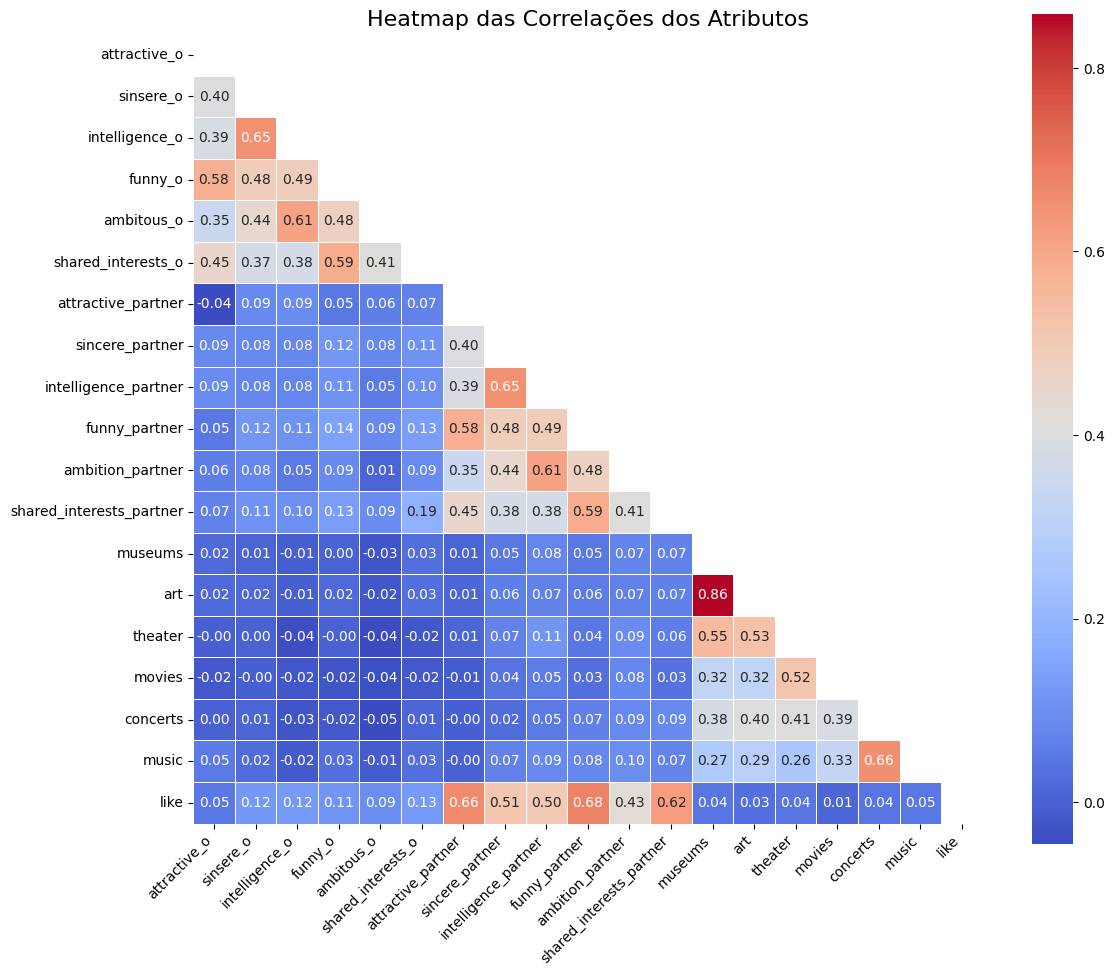

In [25]:
threshold = 0.5

corr_matrix = numeric_columns.corr()

masked_corr = corr_matrix.copy()
np.fill_diagonal(masked_corr.values, np.nan)

significant_columns = masked_corr.columns[
    (masked_corr.abs() > threshold).any(axis=0)
]

filtered_corr_matrix = corr_matrix.loc[significant_columns, significant_columns]

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(filtered_corr_matrix, dtype=bool))
sns.heatmap(
    filtered_corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    square=True,
    annot_kws={'size':10}
)

plt.title("Heatmap das Correlações dos Atributos", fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [26]:
# df["cultural_interest"] = df[["art", "museums", "theater"]].mean(axis=1)
# df["musical_interest"] = df[["music", "concerts"]].mean(axis=1)
# df.drop(["museums", "concerts", "art", "theater", "music"], axis=1, inplace=True)

Como a maior parte das outras correlações não são tão altas (abaixo de 0.7), isso não é muito crítico p modelos preditivos em geral. Além disso, as correlações entre avaliações do parceiro e "like" são esperadas, já que gostar do parceiro provavelmente depende dessas características. Então se, por exemplo, a gente decidir criar um modelo preditivo sobre "like" ou "match", manter essas variáveis separadas faria mais sentido.

E sobre correlações entre características do parceiro e avaliações do parceiro, elas não são tão altas a ponto de causar problemas, então a gente pode deixar como estão, a não ser que um modelo comece a sofrer de multicolinearidade.

Existem muitas colunas sobre atração, inteligência, sinceridade, diversão, ambição, interesses em comum... que aparecem em diferentes contextos, como autoavaliação (intelligence), avaliação do parceiro (intelligence_partner), avaliação feita pelo parceiro (intelligence_o), e importância dessa característica (intelligence_important).

Mesmo que as correlações individuais sejam moderadas, como visto no heatmap, o conjunto completo de variáveis tá carregado de informações parecidas.

In [27]:
def aggregate_highly_correlated_features(df: pd.DataFrame, threshold: float = 0.5) -> pd.DataFrame:
    """
    Identifica colunas com correlação acima de um certo threshold,
    cria novas colunas agregadas e remove as colunas originais correlacionadas.

    Parâmetros:
    df (pd.DataFrame): DataFrame original.
    threshold (float): Valor limite para considerar correlação alta. Default é 0.5.

    Retorna:
    pd.DataFrame: DataFrame transformado com novas colunas agregadas e sem as colunas redundantes.
    """
    df = df.copy()
    original_shape = df.shape  # Guardar tamanho original

    # Selecionando apenas colunas numéricas para o cálculo da correlação
    numeric_df = df.select_dtypes(include=['number'])

    # Calculando matriz de correlação apenas para colunas numéricas
    corr_matrix = numeric_df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identificando colunas altamente correlacionadas
    correlated_groups = {}
    for col in upper_triangle.columns:
        high_corr_cols = upper_triangle.index[upper_triangle[col] > threshold].tolist()
        if high_corr_cols:
            correlated_groups[col] = high_corr_cols

    # Criando colunas agregadas e removendo as originais
    columns_to_drop = set()
    columns_grouped = {}
    for new_col, group in correlated_groups.items():
        group.append(new_col)
        aggregated_col_name = f"{new_col}_aggregated"
        df[aggregated_col_name] = df[group].mean(axis=1)
        columns_to_drop.update(group)
        columns_grouped[aggregated_col_name] = group

    # Removendo colunas originais correlacionadas
    df.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')
    new_shape = df.shape  # Guardar tamanho novo

    # Printar informações detalhadas sobre a transformação
    print("\nColunas removidas:", columns_to_drop)
    print("Novas colunas criadas e seus grupos correspondentes:")
    for new_col, grouped in columns_grouped.items():
        print(f"- {new_col}: agregado de {grouped}")
    print(f"\nShape original: {original_shape} // Shape transformado: {new_shape}")

    return df

In [28]:
df_transformed_05 = aggregate_highly_correlated_features(df, threshold=0.8)


Colunas removidas: {'art', 'museums'}
Novas colunas criadas e seus grupos correspondentes:
- art_aggregated: agregado de ['museums', 'art']

Shape original: (8378, 126) // Shape transformado: (8378, 125)


In [29]:
df_transformed_05 = aggregate_highly_correlated_features(df, threshold=0.6)


Colunas removidas: {'funny_o', 'sinsere_o', 'shared_interests_partner', 'like', 'intelligence_partner', 'music', 'attractive_partner', 'intelligence_o', 'funny_partner', 'sincere_partner', 'art', 'museums', 'concerts', 'shared_interests_o', 'ambition_partner', 'ambitous_o'}
Novas colunas criadas e seus grupos correspondentes:
- intelligence_o_aggregated: agregado de ['sinsere_o', 'intelligence_o']
- ambitous_o_aggregated: agregado de ['intelligence_o', 'ambitous_o']
- shared_interests_o_aggregated: agregado de ['funny_o', 'shared_interests_o']
- intelligence_partner_aggregated: agregado de ['sincere_partner', 'intelligence_partner']
- ambition_partner_aggregated: agregado de ['intelligence_partner', 'ambition_partner']
- shared_interests_partner_aggregated: agregado de ['funny_partner', 'shared_interests_partner']
- art_aggregated: agregado de ['museums', 'art']
- music_aggregated: agregado de ['concerts', 'music']
- like_aggregated: agregado de ['attractive_partner', 'funny_partner',

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

numeric_cols = df.select_dtypes(include=[np.number]).dropna()

vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_cols.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_cols.values, i) for i in range(len(numeric_cols.columns))]

display(vif_data)

,Feature,VIF
0,wave,11.185412
1,age,132.952426
2,age_o,84.512445
3,d_age,3.431007
4,importance_same_race,7.823394
5,importance_same_religion,10.558563
6,pref_o_attractive,39.858736
7,pref_o_sincere,24.105293
8,pref_o_intelligence,35.892835
9,pref_o_funny,24.817500


Vemos uma forte multicolinearidade, com muitas variáveis com o VIF elevado (>10).

O PCA pode diminuir essa dimensionalidade, transformando variáveis altamente correlacionadas em componentes principais não correlacionados, escolhendo apenas os componentes principais mais relevantes.

In [31]:
# Selecionar apenas colunas numéricas para o PCA
numeric_cols = df.select_dtypes(include=['number']).columns
df_numeric = df[numeric_cols]

# Padronizar os dados (PCA é sensível à escala)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

In [32]:
# PCA mantendo 95% da variância
# ao reduzir, apenas 5% da informação mais sutil ou ruído é perdida (considerando a manutenção de 95% da variância)
pca = PCA(n_components=0.95)

# missing values -- mediana
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
df_scaled = imputer.fit_transform(df_scaled)

# PCA
df_pca_95 = pca.fit_transform(df_scaled)

# qnts componentes principais foram criados
print(f"Número de componentes principais mantidos: {df_pca_95.shape[1]}")

Número de componentes principais mantidos: 48


Ou seja, 48 componentes principais são necessários p preservar 95% da variância

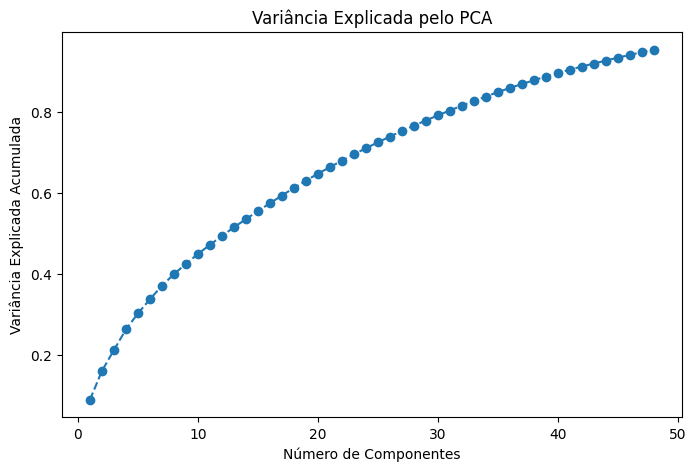

In [33]:
# variância explicada acumulada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada pelo PCA')
plt.show()

In [34]:
# testando outros níveis de variância (ainda altos)

# Variância explicada acumulada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Encontrar número de componentes para diferentes níveis de variância
num_components_85 = np.argmax(explained_variance >= 0.85) + 1
num_components_90 = np.argmax(explained_variance >= 0.90) + 1

print(f"Número de componentes para 85% da variância: {num_components_85}")
print(f"Número de componentes para 90% da variância: {num_components_90}")

Número de componentes para 85% da variância: 36
Número de componentes para 90% da variância: 41


In [35]:
# PCA para 85% da variância
pca_85 = PCA(n_components=num_components_85)
df_pca_85 = pca_85.fit_transform(df_scaled)

# PCA para 90% da variância
pca_90 = PCA(n_components=num_components_90)
df_pca_90 = pca_90.fit_transform(df_scaled)

# PCA para 95% da variância (já feito antes)
pca_95 = PCA(n_components=df_pca_95.shape[1])
df_pca_95 = pca_95.fit_transform(df_scaled)

In [36]:
# df com os loadings (importância das variáveis em cada componente)
loadings_85 = pd.DataFrame(pca_85.components_, columns=df.select_dtypes(include=['number']).columns)

print("Loadings (peso das variáveis em cada componente):")
print(loadings_85.head())  # primeiros 5 componentes

Loadings (peso das variáveis em cada componente):
       wave       age     age_o     d_age  importance_same_race  \
0  0.006149 -0.010255  0.005911  0.004211              0.007716   
1  0.056635  0.004235  0.039630  0.011938              0.055722   
2 -0.025855  0.102127  0.051898  0.055352             -0.091856   
3  0.032024 -0.090677  0.000610 -0.030896              0.086167   
4 -0.112715 -0.271502 -0.041993 -0.103720              0.308260   

   importance_same_religion  pref_o_attractive  pref_o_sincere  \
0                 -0.007458           0.046244       -0.034926   
1                  0.047735           0.086918       -0.026649   
2                 -0.039938           0.063478        0.005149   
3                  0.014657          -0.019127        0.043327   
4                  0.287244           0.234762       -0.113558   

   pref_o_intelligence  pref_o_funny  ...  shopping      yoga  \
0            -0.035636      0.026156  ...  0.149354  0.124220   
1            -0.0214

In [37]:
# variáveis mais importantes p cada componente principal
num_components = 5
top_n = 5

for i in range(num_components):
    print(f"\nComponente Principal {i+1}:")
    sorted_loadings = loadings_85.iloc[i, :].abs().sort_values(ascending=False)  # Ordena pelas mais influentes
    print(sorted_loadings.head(top_n))  # Mostra as top N variáveis mais influentes


Componente Principal 1:
like                        0.278692
funny_partner               0.273919
intelligence_partner        0.259424
shared_interests_partner    0.248338
sincere_partner             0.245080
Name: 0, dtype: float64

Componente Principal 2:
theater     0.310338
museums     0.299671
art         0.289882
movies      0.255582
concerts    0.240432
Name: 1, dtype: float64

Componente Principal 3:
intelligence_o    0.317883
sinsere_o         0.295249
funny_o           0.276901
ambitous_o        0.248265
tvsports          0.247313
Name: 2, dtype: float64

Componente Principal 4:
attractive_o          0.264177
attractive_partner    0.257892
like                  0.249003
funny_o               0.238332
intelligence          0.227083
Name: 3, dtype: float64

Componente Principal 5:
tv                          0.380034
importance_same_race        0.308260
importance_same_religion    0.287244
age                         0.271502
pref_o_attractive           0.234762
Name: 4, dtype

**Considerando uma variância de 85%**

**PC1** (preferência por parceiro): esse componente parece representar a avaliação geral do parceiro baseada nas qualidades percebidas.

-- Se essas variáveis já estão representadas nesse único componente, pode ser possível remover algumas delas se estiverem altamente correlacionadas.

**PC2** (interesse cultural): componente fortemente relacionado a interesses culturais.

-- Se essas variáveis são altamente correlacionadas, é viável criar uma nova variável agregada chamada "cultural_interest", substituindo essas cinco.

**PC3** (avaliação objetiva pelo parceiro): esse componente parece representar como os participantes foram avaliados por seus parceiros.

-- Pode-se manter apenas algumas delas e, alternativamente, pode-se criar um novo atributo "partner_rating" que combine as avaliações dos parceiros.

...

In [38]:
# criação de um dataset reduzido para armazenar novas variáveis, mas não perder a antiga
df_reduced = df.copy()

# criando variáveis agregadas com a média das variáveis correlacionadas

# preferência por parceiro (PC1)
df_reduced["preference_for_partner"] = df_reduced[["funny_partner", "intelligence_partner", "shared_interests_partner", "sincere_partner"]].mean(axis=1)

# interesse cultural (PC2)
df_reduced["cultural_interest"] = df_reduced[["theater", "museums", "art", "movies", "concerts"]].mean(axis=1)

# avaliação pelo parceiro (PC3)
df_reduced["partner_rating"] = df_reduced[["intelligence_o", "sinsere_o", "funny_o", "ambitous_o"]].mean(axis=1)

# atratividade (PC4)
df_reduced["attractiveness"] = df_reduced[["attractive_o", "attractive_partner"]].mean(axis=1)

# preferências pessoais (PC5)
df_reduced["personal_preferences"] = df_reduced[["importance_same_race", "importance_same_religion"]].mean(axis=1)

# removendo as colunas originais correlacionadas que foram agregadas
columns_to_remove = [
    "theater", "museums", "art", "movies", "concerts",
    "intelligence_o", "sinsere_o", "funny_o", "ambitous_o",
    "attractive_o", "attractive_partner",
    "importance_same_race", "importance_same_religion",
    "funny_partner", "intelligence_partner", "shared_interests_partner", "sincere_partner"
]

df_reduced.drop(columns=columns_to_remove, inplace=True)

print(f"Dataset reduzido c {df_reduced.shape[1]} colunas; antes: {df.shape[1]})")

Dataset reduzido c 114 colunas; antes: 126)


In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Selecionar apenas colunas numéricas para calcular o VIF
numeric_cols_reduced = df_reduced.select_dtypes(include=['number'])

# Remover linhas com valores infinitos ou NaN antes de calcular o VIF
numeric_cols_reduced = numeric_cols_reduced.replace([np.inf, -np.inf], np.nan).dropna()

# Calcular o VIF para cada variável no dataset reduzido
vif_data_reduced = pd.DataFrame()
vif_data_reduced["Feature"] = numeric_cols_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(numeric_cols_reduced.values, i) for i in range(numeric_cols_reduced.shape[1])]

# Exibir os resultados
print("VIF após a redução de variáveis:")
print(vif_data_reduced)

VIF após a redução de variáveis:
                          Feature         VIF
0                            wave   10.844394
1                             age  108.049909
2                           age_o   79.567043
3                           d_age    3.272944
4               pref_o_attractive   37.052089
5                  pref_o_sincere   23.431020
6             pref_o_intelligence   33.663341
7                    pref_o_funny   23.168900
8                pref_o_ambitious    7.266546
9         pref_o_shared_interests   10.418816
10             shared_interests_o   13.640346
11           attractive_important   35.615245
12              sincere_important   28.207192
13         intellicence_important   40.852547
14                funny_important   22.690048
15            ambtition_important    8.968173
16     shared_interests_important   14.767507
17                     attractive   55.794917
18                        sincere   78.647041
19                   intelligence   53.899839
2

- O VIF deu uma diminuida, mas ainda há variáveis com valores elevados, podendo ser necessário remover mais algumas variáveis, dependendo do que poderá vir a ser feito posteriormente nas modelagens.
- Mantendo mais informações no dataset, como está, podemos ver depois na fase da modelagem se isso afeta o desempenho dos modelos. Se sim, poderemos dar continuidade a essa diminuição/remoção e testar ambos os cenários.

### Features categóricas

In [41]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)

Index(['has_null', 'gender', 'd_d_age', 'race', 'race_o', 'samerace',
       'd_importance_same_race', 'd_importance_same_religion', 'field',
       'd_pref_o_attractive', 'd_pref_o_sincere', 'd_pref_o_intelligence',
       'd_pref_o_funny', 'd_pref_o_ambitious', 'd_pref_o_shared_interests',
       'd_attractive_o', 'd_sinsere_o', 'd_intelligence_o', 'd_funny_o',
       'd_ambitous_o', 'd_shared_interests_o', 'd_attractive_important',
       'd_sincere_important', 'd_intellicence_important', 'd_funny_important',
       'd_ambtition_important', 'd_shared_interests_important', 'd_attractive',
       'd_sincere', 'd_intelligence', 'd_funny', 'd_ambition',
       'd_attractive_partner', 'd_sincere_partner', 'd_intelligence_partner',
       'd_funny_partner', 'd_ambition_partner', 'd_shared_interests_partner',
       'd_sports', 'd_tvsports', 'd_exercise', 'd_dining', 'd_museums',
       'd_art', 'd_hiking', 'd_gaming', 'd_clubbing', 'd_reading', 'd_tv',
       'd_theater', 'd_movies', 'd_c

<ipython-input-40-5a752cf435b4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_before, x=col, order=df_before[col].value_counts().index, palette="viridis")
<ipython-input-40-5a752cf435b4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_before, x=col, order=df_before[col].value_counts().index, palette="viridis")
<ipython-input-40-5a752cf435b4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_before, x=col, order=df_before[col].value_counts().index, palette="viridis")
<ipython-input-40-5a752cf435b4>:11: Futu

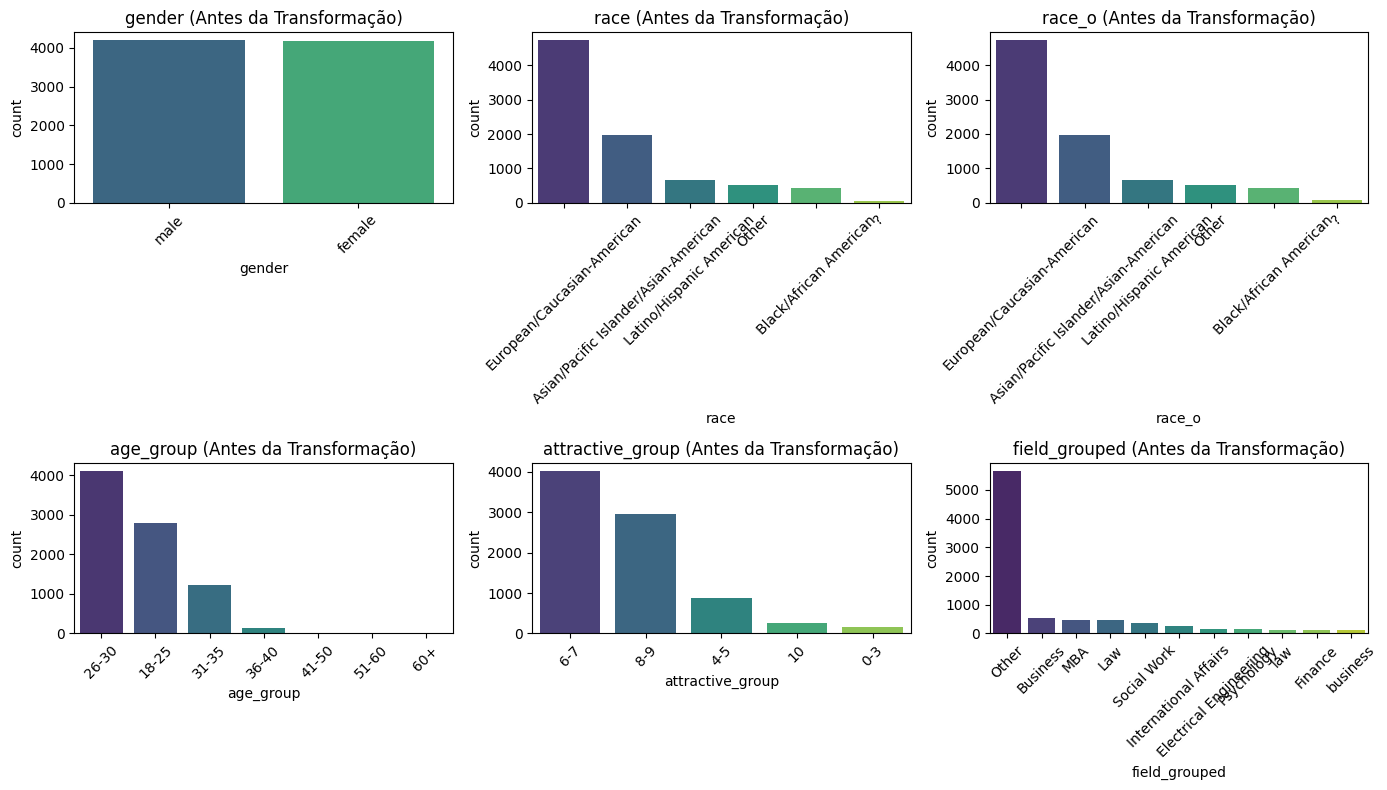

In [40]:
df_before = df.copy()  # cópia do dataset antes das transformações

# Listar as colunas categóricas originais
categorical_cols_before = ["gender", "race", "race_o", "age_group", "attractive_group", "field_grouped"]

# Criar gráficos de barras para visualizar a distribuição das categorias antes da transformação
plt.figure(figsize=(14, 8))

for i, col in enumerate(categorical_cols_before):
    plt.subplot(2, 3, i+1)  # Criando subplots
    sns.countplot(data=df_before, x=col, order=df_before[col].value_counts().index, palette="viridis")
    plt.xticks(rotation=45)
    plt.title(f"{col} (Antes da Transformação)")

plt.tight_layout()
plt.show()

In [42]:
#  identificar quantas categorias cada variável tem p escolher o melhor método de conversão (One-Hot, Label Encoding ou Target Encoding).
for col in categorical_cols:
    print(f"\n{col} - Valores únicos:")
    print(df[col].value_counts())


has_null - Valores únicos:
has_null
1    7330
0    1048
Name: count, dtype: int64

gender - Valores únicos:
gender
male      4194
female    4184
Name: count, dtype: int64

d_d_age - Valores únicos:
d_d_age
[2-3]     2406
[4-6]     2316
[0-1]     2227
[7-37]    1429
Name: count, dtype: int64

race - Valores únicos:
race
European/Caucasian-American              4727
Asian/Pacific Islander/Asian-American    1982
Latino/Hispanic American                  664
Other                                     522
Black/African American                    420
?                                          63
Name: count, dtype: int64

race_o - Valores únicos:
race_o
European/Caucasian-American              4722
Asian/Pacific Islander/Asian-American    1978
Latino/Hispanic American                  664
Other                                     521
Black/African American                    420
?                                          73
Name: count, dtype: int64

samerace - Valores únicos:
samerace
0   

**Variáveis binárias**
- gender (male, female) - ok
- samerace (0, 1) - ok
- decision e decision_o (0 = rejeição, 1 = aceitação) - ok

**Variáveis c poucas categorias**
- race e race_o: tem 6 categorias, mas uma delas é "?" (dado faltante) -- tratar (?)
- age_group: Idade já agrupada em faixas
- attractive_group: escala já categorizada (0-3, 4-5, 6-7, etc.).

//Criar One-Hot Encoding para essas variáveis.

**Variáveis c muitas categorias**
- field c 260 categorias
- field_grouped: versão agrupada de field, mas que ainda tem 11 categorias -- pode ser codificada via Target Encoding

Usar field_grouped e ignorar field, pois a versão agrupada é mais eficiente.

**Variáveis categóricas que são faixas numéricas**
- ao invés de tratá-las como variáveis categóricas, faz mais sentido transformá-las em valores numéricos contínuos
- a conversão permitirá capturar mais variação nos dados

In [43]:
df.drop(columns=["field"], inplace=True)
df.drop(columns=["age"], inplace=True)

- field_grouped agrupa field em 11 categorias, tornando a modelagem mais eficiente e generalizável, diferente de field com 260 categorias (poderia ser problemático). então é aceitável excluí-la.
- mesma coisa vale para age, que já foi agrupada em age_grouped, evitando overfitting e reduzindo complexidade

In [44]:
# label encoding p gender, age_group e attractive_group

le = LabelEncoder()

df["gender"] = le.fit_transform(df["gender"])
df["age_group"] = le.fit_transform(df["age_group"])
df["attractive_group"] = le.fit_transform(df["attractive_group"])

- gender agora vira 0 para male e 1 para female.
- age_group e attractive_group são convertidos para números, preservando a ordem

📌 como essas variáveis são ordinais, então Label Encoding é mais adequado

In [45]:
df["field_encoded"] = df.groupby("field_grouped")["match"].transform("mean")
df.drop(columns=["field_grouped"], inplace=True)

In [46]:
print(df[["field_encoded", "match"]].head())

   field_encoded  match
0       0.212121      0
1       0.212121      0
2       0.212121      1
3       0.212121      1
4       0.212121      1


- field_grouped foi substituído pela taxa média de match dentro de cada grupo, ajudando na modelagem.
- coluna original removida.

📌 tendo em vista que match é uma variável-alvo, faz sentido usar target encoding para substituir cada categoria de field_grouped pela taxa média de match dentro dessa categoria. assim, se certas áreas de estudo influenciam mais no sucesso do speed dating (exemplo: quem faz MBA tem mais matches), então essa informação pode ser útil p modelo. -- podemos usar o impacto da categoria no match para ajudar o modelo a aprender padrões.

In [47]:
# One-Hot Encoding para 'race' e 'race_o'
df = pd.get_dummies(df, columns=["race", "race_o"], drop_first=True)

- race e race_o foram convertidos em colunas binárias (0 ou 1)
- drop_first=True para evitar multicolinearidade

📌 permite que o modelo interprete cada raça como uma variável independente.

In [48]:
# le = LabelEncoder()
# df["age_grouped"] = le.fit_transform(df["age_group"])

In [49]:
# df_one_hot = pd.get_dummies(df, columns=["age_group"], drop_first=True)

- ideal: na fase 4 testar label encoding (útil p regressão logística - variáveis ordenadas) e one hot encoding (útil p random forest ou xgboost) p escolher qual funciona melhor

In [50]:
def convert_range_to_mean(value):
    """
    Converte uma string representando uma faixa numérica (ex: '[0-5]') para a média dos valores dentro da faixa.
    Se o valor já for um número, retorna como float.
    """
    if isinstance(value, str) and re.match(r"\[\-?\d+(\.\d+)?\s*-\s*\-?\d+(\.\d+)?\]", value):
        # Extrair os números da faixa
        numbers = [float(n) for n in re.findall(r"-?\d+\.?\d*", value)]
        return sum(numbers) / len(numbers)  # Retorna a média
    else:
        try:
            return float(value)  # Retorna o valor como float se já for numérico
        except ValueError:
            return value  # Retorna como está se não puder ser convertido

- lida com as colunas que possuem faixas numéricas, extraindo os números das faixas ([x-y]) e calculando a média

In [51]:
# colunas que começam com "d_"
categorical_numerical_cols = [col for col in df.columns if col.startswith("d_")]

# conversão automatica
df[categorical_numerical_cols] = df[categorical_numerical_cols].applymap(convert_range_to_mean)

# Forçar conversão para float para garantir que todas estão no formato correto
df[categorical_numerical_cols] = df[categorical_numerical_cols].astype(float)

Features categóricas restantes (se houver): Index(['has_null', 'samerace', 'decision', 'decision_o'], dtype='object')


<ipython-input-51-0015d2736cf3>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[categorical_numerical_cols] = df[categorical_numerical_cols].applymap(convert_range_to_mean)


In [52]:
# converter para int, garantindo que são numéricas (já estao em formato numérico (0/1))
df["has_null"] = df["has_null"].astype(int)
df["samerace"] = df["samerace"].astype(int)
df["decision"] = df["decision"].astype(int)
df["decision_o"] = df["decision_o"].astype(int)

# verifica se ainda tem valores categóricos
categorical_remaining = df.select_dtypes(include=['object', 'category']).columns
print("Features categóricas restantes:", categorical_remaining)

Features categóricas restantes: Index([], dtype='object')


In [55]:
for col in categorical_remaining:
    print(f"\n{col} - Valores únicos:")
    print(df[col].unique())

In [56]:
scaler = StandardScaler()
df[categorical_numerical_cols] = scaler.fit_transform(df[categorical_numerical_cols])

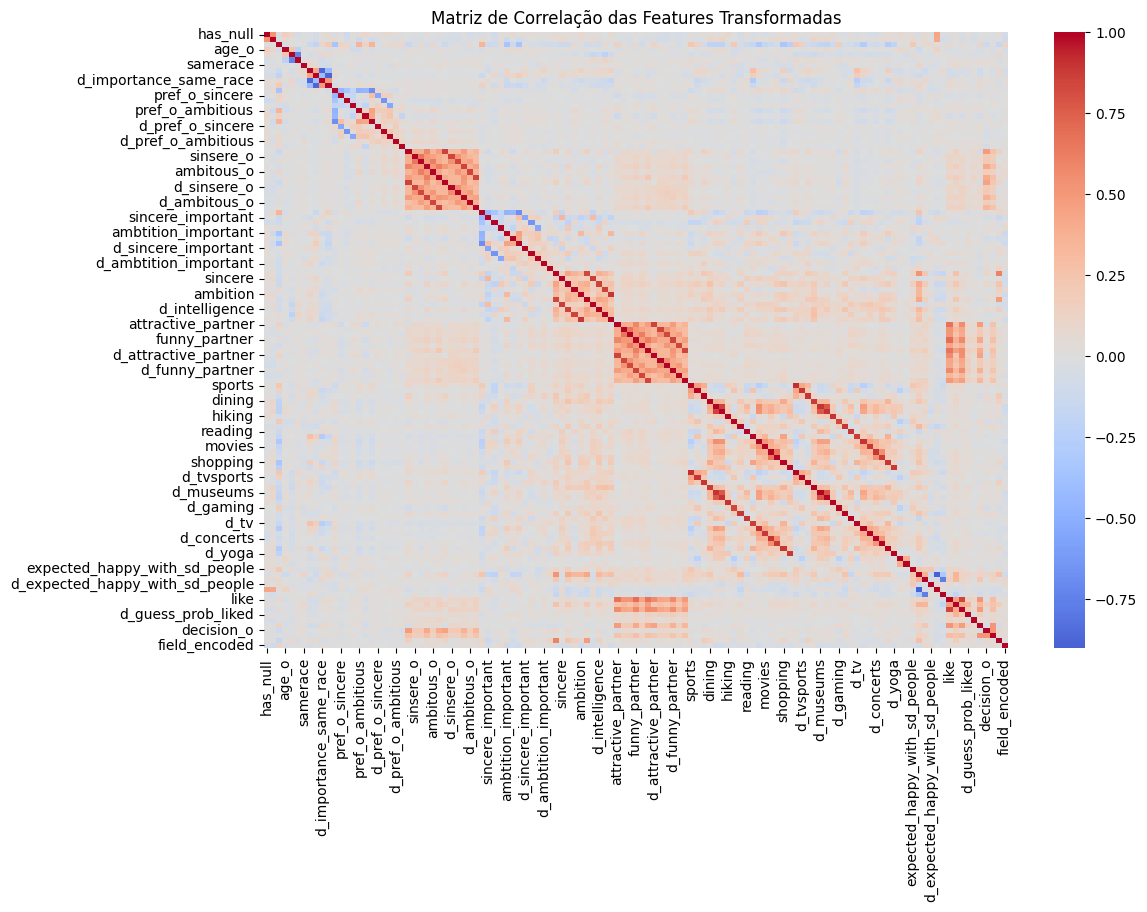

In [60]:
plt.figure(figsize=(12, 8))
# Select only numerical features for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), cmap='coolwarm', annot=False, center=0)
plt.title("Matriz de Correlação das Features Transformadas")
plt.show()

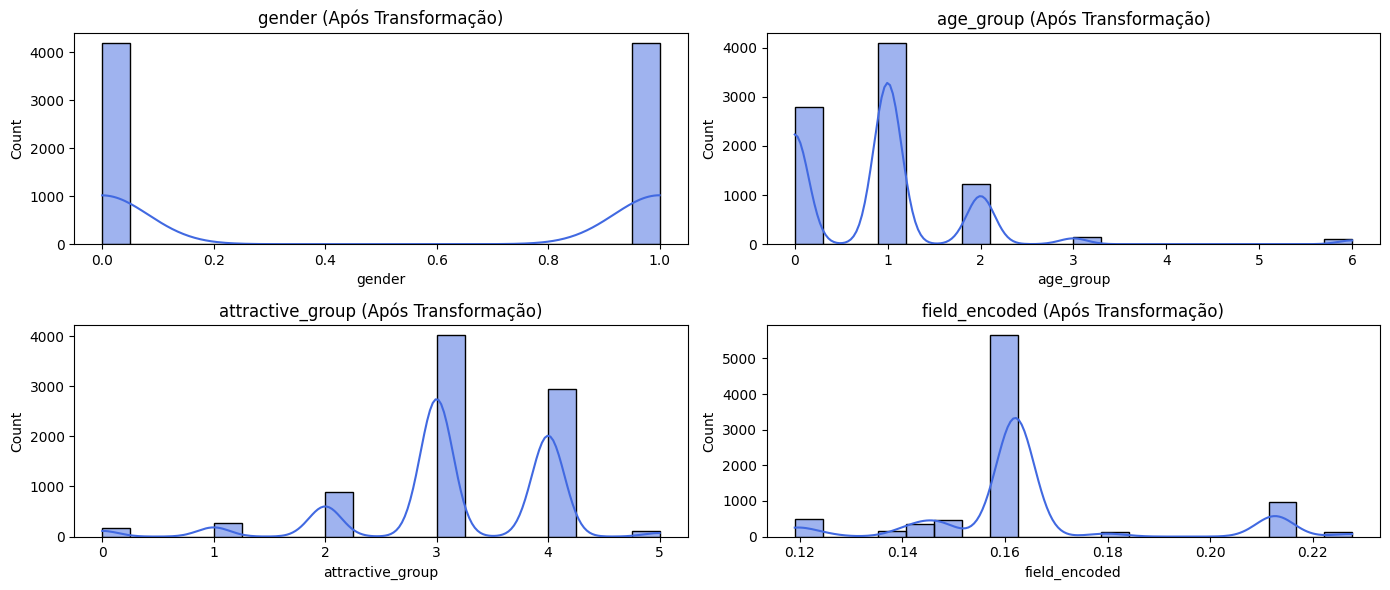

In [63]:
# após a transformação (convertidas para numéricas)
plt.figure(figsize=(14, 6))
transformed_cols = ["gender", "age_group", "attractive_group", "field_encoded"]

for i, col in enumerate(transformed_cols):
    plt.subplot(2, 2, i+1)
    # handling errors by coercing to NaN
    numeric_data = pd.to_numeric(df[col], errors='coerce')
    sns.histplot(numeric_data, bins=20, kde=True, color="royalblue")
    plt.title(f"{col} (Após Transformação)")

plt.tight_layout()
plt.show()